<a href="https://colab.research.google.com/github/hufsaim/T10306201/blob/master/notebook/Lab06.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data augmentation and Implementation of CNN

- PyTorch를 이용하여 주어진 CNN architecture를 구현하고, cifar-10 dataset에 data augmentation을 적용하여 모델을 훈련해봅니다. 

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

- print(device)를 통해 cuda가 출력되어 GPU를 활용할 수 있음을 확인합니다.

In [3]:
if torch.cuda.is_available():
  device = torch.device('cuda:0')
else:
  device = torch.device('cpu')

print(device)

cuda:0


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
path2 = '<your path>'

- torchvision의 다양한 종류의 transform들을 제공하고 있어 영상데이터의 augmentation에 활용할 수 있으며, 또한 자신만의 transform function을 만들어 활용할 수 있습니다.
- https://pytorch.org/docs/stable/torchvision/transforms.html

In [6]:
transform_train = transforms.Compose(
    [transforms.RandomHorizontalFlip(),
     transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.3),
     transforms.RandomAffine((-10,10), shear=10, scale=(0.99, 1.01)),
     transforms.Resize((34,34)),
     transforms.CenterCrop(32),
     transforms.ToTensor()]
     )
transform_valid = transforms.Compose(
    [transforms.ToTensor()]
    )

cifar10_train = torchvision.datasets.CIFAR10(path2, train=True, transform=transform_train, target_transform=None, download=True)
cifar10_valid = torchvision.datasets.CIFAR10(path2, train=False, transform=transform_valid, target_transform=None, download=True)
def get_cifar10_labels(labels):
    text_labels = ['airplane', 'car', 'bird', 'cat', 'deer',
                   'dog', 'frog', 'horse', 'ship', 'truck']
    return [text_labels[int(i)] for i in labels]

# defining data_iter, linreg. model, loss, sgd
batch_size = 100
num_workers = 0
train_iter = DataLoader(cifar10_train, batch_size, shuffle=True, num_workers=num_workers)
valid_iter = DataLoader(cifar10_valid, batch_size, shuffle=False, num_workers=num_workers)

Files already downloaded and verified
Files already downloaded and verified


- cifar10 데이터에 대해 살펴봅니다.

In [7]:
cifar10_train

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: /content/drive/My Drive/Class/2020-2-bme-dip/data03/
    Split: Train
    StandardTransform
Transform: Compose(
               RandomHorizontalFlip(p=0.5)
               ColorJitter(brightness=[0.7, 1.3], contrast=[0.7, 1.3], saturation=[0.7, 1.3], hue=[-0.3, 0.3])
               RandomAffine(degrees=[-10.0, 10.0], scale=(0.99, 1.01), shear=[-10.0, 10.0])
               Resize(size=(34, 34), interpolation=PIL.Image.BILINEAR)
               CenterCrop(size=(32, 32))
               ToTensor()
           )

In [8]:
cifar10_valid

Dataset CIFAR10
    Number of datapoints: 10000
    Root location: /content/drive/My Drive/Class/2020-2-bme-dip/data03/
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
           )

torch.Size([100])
torch.Size([100, 3, 32, 32])


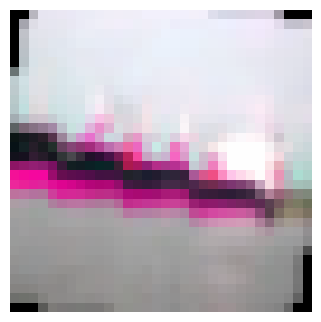

['ship']


In [9]:
dataiter=iter(train_iter)
images, labels = dataiter.next()
print(labels.shape)
print(images.shape)
I = images[0].numpy()
plt.figure(dpi=100)

plt.imshow(np.transpose(I,[1,2,0]),cmap='gray')
plt.axis('off')
plt.show()
print(get_cifar10_labels([labels[0]]))

- PyTorch에서 제공하는 유명한 CNN architecture를 가져와서 구조를 살펴봅니다.
- PyTorch에서는 resnet, densenet 등 유명한 network를 쉽게 불러와서 활용할 수 있습니다. 
- 여기서는 vgg16 을 가져와 보겠습니다.
- https://pytorch.org/hub/research-models 

In [12]:
vgg16 = torch.hub.load('pytorch/vision:v0.6.0', 'vgg16', pretrained=False)
vgg16

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

- 위에서 출력한 network구조를 참고하여 Vgg와 유사한 network를 직접 구현해 봅시다.
- 위의 network는 input image가 224 x 224 정도인 경우에 대해 고안된 것이므로, 우리는 32x32의 매우 작은 input image를 다루고 있기 때문에 이를 고려하여야 합니다.

In [17]:
class Flatten(torch.nn.Module):
    def forward(self, x):
        return x.view(x.shape[0], -1)

net = torch.nn.Sequential(
    
    nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, stride=1,padding=1),
    nn.ReLU(),
    nn.Conv2d(in_channels=8, out_channels=8, kernel_size=3, stride=1,padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2,stride=2), # 8 x 16 x 16

    nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=1,padding=1),
    nn.ReLU(),
    nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, stride=1,padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2,stride=2), # 16 x 8 x 8

    nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1,padding=1),
    nn.ReLU(),
    nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1,padding=1),
    nn.ReLU(),    
    nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1,padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2,stride=2),  # 32 x 4 x 4

    nn.AdaptiveAvgPool2d(output_size = (3, 3)), # 32 x 3 x 3
        
    Flatten(),

    nn.Linear(in_features=32*3*3, out_features=128,bias=True),
    nn.ReLU(),
    nn.Dropout(p=0.5),    
    nn.Linear(in_features=128, out_features=10,bias=True)


)

net = net.to(device)
net

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU()
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU()
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU()
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU()
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU()
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU()
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): AdaptiveAvgPool2d(output_size=(3, 3))
  (18): Flatten()
  (19): Linear(in_features=2304, out_features=256, bia

- 임의로 random tensor를 생성하여, network의 각 layer에 shape을 확인해봅니다.

In [18]:
X = torch.randn(size=(1,3,32,32), dtype = torch.float32)
X = X.to(device)
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape: \t',X.shape)

Conv2d output shape: 	 torch.Size([1, 64, 32, 32])
ReLU output shape: 	 torch.Size([1, 64, 32, 32])
Conv2d output shape: 	 torch.Size([1, 64, 32, 32])
ReLU output shape: 	 torch.Size([1, 64, 32, 32])
MaxPool2d output shape: 	 torch.Size([1, 64, 16, 16])
Conv2d output shape: 	 torch.Size([1, 128, 16, 16])
ReLU output shape: 	 torch.Size([1, 128, 16, 16])
Conv2d output shape: 	 torch.Size([1, 128, 16, 16])
ReLU output shape: 	 torch.Size([1, 128, 16, 16])
MaxPool2d output shape: 	 torch.Size([1, 128, 8, 8])
Conv2d output shape: 	 torch.Size([1, 256, 8, 8])
ReLU output shape: 	 torch.Size([1, 256, 8, 8])
Conv2d output shape: 	 torch.Size([1, 256, 8, 8])
ReLU output shape: 	 torch.Size([1, 256, 8, 8])
Conv2d output shape: 	 torch.Size([1, 256, 8, 8])
ReLU output shape: 	 torch.Size([1, 256, 8, 8])
MaxPool2d output shape: 	 torch.Size([1, 256, 4, 4])
AdaptiveAvgPool2d output shape: 	 torch.Size([1, 256, 3, 3])
Flatten output shape: 	 torch.Size([1, 2304])
Linear output shape: 	 torch.Size([

- Learning rate, num_epochs, loss function, backpropagation algorithm을 정해줍니다..

In [19]:
# setting hyper-parameters
learning_rate = 0.1
num_epochs = 100

# loss function and algorithm
loss = torch.nn.CrossEntropyLoss() # loss
alg = torch.optim.SGD(net.parameters(),lr=learning_rate) # sgd

- 네트워크에 대한 훈련을 진행합니다. 매 10회마다 결과를 출력하게 하였습니다. train, valid accuracy의 변화를 관찰합니다.
- 최종결과가 만족스럽지 않은 경우에는 hyper-parameter를 바꾸어가며 다시 학습을 진행합니다.
- input data에 대한 random transformation을 추가하는 것은 overfitting에 도움을 줄 수 있습니다.
- vggnet이나 resnet과 같이 좀 더 효율적인 네트워크 구조를 적용해 볼 수도 있습니다.

In [ ]:
# training the model
loss_train = np.array([])
accs_train = np.array([])
accs_valid = np.array([])

for epoch in range(num_epochs):
  i=0
  l_epoch = 0
  correct = 0
  for X,y in train_iter:
    i=i+1
    X,y = X.to(device),y.to(device) # GPU 
    y_hat=net(X)
    correct += (y_hat.argmax(dim=1)==y).sum()
    l=loss(y_hat,y)
    l_epoch+=l
    alg.zero_grad()
    l.backward()
    alg.step()

  loss_train = np.append(loss_train,l_epoch.cpu().detach().numpy()/i)
  accs_train = np.append(accs_train,correct.cpu()/50000.)

  correct = 0
  for X,y in valid_iter:
    X,y = X.to(device),y.to(device)
    y_hat = net(X)
    correct += (y_hat.argmax(dim=1)==y).sum()

  accs_valid = np.append(accs_valid,correct.cpu()/10000.)


  if epoch%10 == 0:
    plt.plot(loss_train,label='train loss')
    plt.plot(accs_train,label='train accuracy')
    plt.plot(accs_valid,label='valid accuracy')
    plt.legend(loc='lower left')
    plt.title('epoch: %d '%(epoch))
    plt.pause(.0001)

    print('train loss: ',loss_train[-1])
    print('train accuracy: ',accs_train[-1])
    print('valid accuracy: ',accs_valid[-1])

In [ ]:
print('valid_accuracy: ',accs_valid[-1])


- validation set의 몇몇 example에 대한 결과를 관찰해 봅니다.

In [ ]:
i = 0
for X,y in valid_iter:
  i=i+1
  X=X.to(device)
  y_hat = net(X)    
  y_hat = y_hat.argmax(dim=1)
  for n in range(4):
    plt.figure(dpi=100)
    plt.imshow(np.transpose(X[n].cpu().squeeze(),[1,2,0]),cmap='gray')
    plt.title('label: %s \n prediction: %s'%(get_cifar10_labels([y[n]]),get_cifar10_labels([y_hat[n]])))
    plt.axis('off')
    plt.pause(.0001)
  if i>2:
     break